In [1]:
%cd ../..

/home/rasmusj/code


In [2]:
import sys
import random

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib
import tensorflow.train
from tensorflow.keras import layers
from gconvnet import GConv2D, GMaxPool
import gconvnet.groups as groups

In [3]:
print('Tensorflow version: {}'.format(tf.__version__))
print('Keras      version: {}'.format(tf.keras.__version__))
print('Numpy version:      {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Python version:     {}'.format(sys.version))

Tensorflow version: 1.14.0
Keras      version: 2.2.4-tf
Numpy version:      1.16.4
Matplotlib version: 3.1.0
Python version:     3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


We now load the MNIST data. It is organized as follows:
* Each samples is represented as 785 scalars. The first 24*24=784 are the pixel values. The last is the label.
* mnist_train.amat contains 12,000 samples. The first 10,000 are training samples, the last 2000 are validation samples.
* mnist_test.amat contains 50,000 test samples.

In [4]:
train_n = 10000 
val_n = 2000
test_n = 50000
sample_width = 28
sample_height = 28

In [5]:
raw_train_val_data = np.loadtxt('gconvnet/examples/mnist_all_rotation_normalized_float_train_valid.amat')
raw_test_data = np.loadtxt('gconvnet/examples/mnist_all_rotation_normalized_float_test.amat')

In [6]:
assert raw_train_val_data.shape[0] == train_n + val_n, \
       'mnist_train.amat had unexpected number of samples'
assert raw_test_data.shape[0] == test_n, \
       'mnist_test.amat had unexpected number of samples'

assert raw_train_val_data.shape[1] == sample_width*sample_height + 1, \
    "mnist_train.amat samples have wrong size, expected {0} got {1}".format(
           sample_width*sample_height+1, raw_train_val_data.shape[1])
assert raw_test_data.shape[1] == sample_width*sample_height + 1, \
    "mnist_test.amat samples have wrong size, expected {0} got {1}".format(
           sample_width*sample_height+1, raw_test_data.shape[1])

train_x = raw_train_val_data[:train_n,:-1].reshape(train_n,sample_width,sample_height,1,1)
train_y = raw_train_val_data[:train_n,-1]

val_x = raw_train_val_data[train_n:,:-1].reshape(val_n,sample_width,sample_height,1,1)
val_y = raw_train_val_data[train_n:,-1]

test_x = raw_test_data[:,:-1].reshape(test_n,sample_width,sample_height,1,1)
test_y = raw_test_data[:,-1]

train_data = {
    'x' : train_x,
    'y' : train_y,
    'y_cat' : tf.keras.utils.to_categorical(train_y,10),
    'name' : 'train',
    'n' : train_n}
test_data = {
    'x' : test_x,
    'y' : test_y,
    'y_cat' : tf.keras.utils.to_categorical(test_y,10),
    'name' : 'test',
    'n' : test_n}
val_data = {
    'x' : val_x,
    'y' : val_y,
    'y_cat' : tf.keras.utils.to_categorical(val_y,10),
    'name' : 'validation',
    'n' : val_n}

# Inspection

Train dataset sample #3689 with label: 6.0


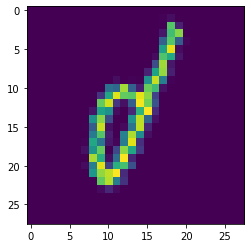

In [7]:
dataset_to_inspect = train_data
example_idx = -1 # index of sample to inspect. -1 for random.

if example_idx == -1:
    example_idx = random.randint(0,dataset_to_inspect['n']-1)

assert (example_idx >= 0 and example_idx < dataset_to_inspect['n']-1), \
    'Example index out of bounds'

example_x = dataset_to_inspect['x'][example_idx].reshape(sample_width,sample_height)
example_y = dataset_to_inspect['y'][example_idx]

plt.imshow(example_x)

print('{0} dataset sample #{1} with label: {2}'.format(
    dataset_to_inspect['name'].capitalize(), example_idx, example_y))

# Model

In [8]:
subgroup = groups.create_inclusion(groups.c4, [0,2])

In [9]:
custommodel = keras.Sequential()
custommodel.add(GConv2D(30, 
                        kernel_size=(3,3),
                        input_shape=(28,28,1,1),
                        G = 'c4',
                        G_action = 'rot90',
                        activation='relu',
                        use_bias = False,
                        name='GConv1'))
custommodel.add(GConv2D(30,
                       kernel_size=(3,3),
                       G='c4',
                       G_action = 'rot90',
                       activation='relu',
                       use_bias=False,
                       name='GConv2'))
custommodel.add(GConv2D(30,
                       kernel_size=(3,3),
                       G='c4',
                       G_action = 'rot90',
                       activation='relu',
                       use_bias=False,
                       name='GConv3'))
custommodel.add(GMaxPool(subgroup,
                        name='GMaxPool1'))
custommodel.add(layers.Flatten())
custommodel.add(layers.Dense(10, activation='softmax'))

W0925 23:04:35.739358 139772620162880 deprecation.py:506] From /home/rasmusj/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


-1 1 1
-1 1 1
-1 1 1
-1 1 1
-1 1 1
-1 1 1
[-1 -1]
[ 0 -1]
[0 1]
[0 1]


In [10]:
custommodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GConv1 (GConv2D)             (None, 26, 26, 4, 30)     270       
_________________________________________________________________
GConv2 (GConv2D)             (None, 24, 24, 4, 30)     32400     
_________________________________________________________________
GConv3 (GConv2D)             (None, 22, 22, 4, 30)     32400     
_________________________________________________________________
GMaxPool1 (GMaxPool)         (None, 22, 22, 2, 30)     0         
_________________________________________________________________
flatten (Flatten)            (None, 29040)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                290410    
Total params: 355,480
Trainable params: 355,480
Non-trainable params: 0
__________________________________________________

In [11]:
custommodel.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [12]:
custommodel.fit(
    train_data['x'],
    train_data['y_cat'],
    batch_size=128,
    epochs=10)

Epoch 1/10
10000/10000 [==============================] - 5s 521us/sample - loss: 1.0852 - acc: 0.6337
Epoch 2/10
10000/10000 [==============================] - 3s 340us/sample - loss: 0.5285 - acc: 0.8285
Epoch 3/10
10000/10000 [==============================] - 3s 347us/sample - loss: 0.3593 - acc: 0.8873
Epoch 4/10
10000/10000 [==============================] - 3s 345us/sample - loss: 0.2595 - acc: 0.9178
Epoch 5/10
10000/10000 [==============================] - 3s 346us/sample - loss: 0.1622 - acc: 0.9445
Epoch 6/10
10000/10000 [==============================] - 3s 346us/sample - loss: 0.1097 - acc: 0.9626
Epoch 7/10
10000/10000 [==============================] - 3s 346us/sample - loss: 0.0847 - acc: 0.9710
Epoch 8/10
10000/10000 [==============================] - 3s 349us/sample - loss: 0.0482 - acc: 0.9838
Epoch 9/10
10000/10000 [==============================] - 3s 347us/sample - loss: 0.0256 - acc: 0.9918
Epoch 10/10
10000/10000 [==============================] - 3s 347us/sampl

In [13]:
custommodel.evaluate(val_data['x'],val_data['y_cat'])

2000/2000 [==============================] - 0s 200us/sample - loss: 0.9159 - acc: 0.8460


[0.9159331638813019, 0.846]